In [ ]:
!pip install keras-cv==0.5.1
!pip install keras-core

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 742.0/742.0 kB 14.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 14.4 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
import keras
import keras_cv
import tensorflow_datasets as tfds
from tensorflow import data as tf_data
from keras_cv import bounding_box
from keras_cv import visualization
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm.auto import tqdm
import xml.etree.ElementTree as ET
from PIL import Image, ImageDraw
import os
import re
import sys
import numpy as np

In [ ]:
os.environ["KERAS_BACKEND"] = "jax"  # @param ["tensorflow", "jax", "torch"]

In [ ]:
print("TensorFlow version:", tf.__version__)
print("Keras version:", keras.__version__)
print("KerasCV version:", keras_cv.__version__)

TensorFlow version: 2.15.0
Keras version: 2.15.0
KerasCV version: 0.5.1


In [ ]:
# Hyperparameters
SPLIT_RATIO = 0.2
BATCH_SIZE = 4
LEARNING_RATE = 0.001
EPOCH = 5
GLOBAL_CLIPNORM = 10.0
IMAGE_WIDTH = 640  # Replace with actual image width
IMAGE_HEIGHT = 480  # Replace with actual image height

class_ids = [
    "big bus",
    "big truck",
    "bus-l-",
    "bus-s-",
    "car",
    "mid truck",
    "small bus",
    "small truck",
    "truck-l-",
    "truck-m-",
    "truck-s-",
    "truck-xl-"
]

In [ ]:
# Convert class_ids to integers for mapping
class_mapping = dict(zip(range(len(class_ids)), class_ids))

In [ ]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to images and labels
path_images = "/content/drive/MyDrive/Vehicles Dataset/images"
path_labels = "/content/drive/MyDrive/Vehicles Dataset/labels"

In [ ]:
# Get all image file paths in path_images and sort them
image_files = sorted(
    [
        os.path.join(path_images, file_name)
        for file_name in os.listdir(path_images)
        if file_name.endswith(".jpg")
    ]
)

# Get all label file paths in path_labels and sort them
label_files = sorted(
    [
        os.path.join(path_labels, file_name)
        for file_name in os.listdir(path_labels)
        if file_name.endswith(".txt")
    ]
)

In [ ]:
print("Count of TXT Files:", len(image_files))
print("Count of Image Files:", len(label_files))

Count of TXT Files: 4058
Count of Image Files: 4058


In [ ]:
def parse_annotation(image_file):
    # Construct label file path from image file path
    label_file = os.path.join(path_labels, os.path.splitext(os.path.basename(image_file))[0] + ".txt")

    try:
        # Read label file
        with open(label_file, "r") as f:
            lines = f.readlines()
    except FileNotFoundError:
        print(f"Warning: Label file not found for {image_file}. Skipping.")
        return None, None, None

    boxes = []
    classes = []
    for line_number, line in enumerate(lines):
        # Each line in the label file represents a bounding box
        values = line.strip().split()

        if len(values) != 5:
            print(f"Warning: Invalid annotation format in {label_file}, line {line_number + 1}. Skipping.")
            continue

        try:
            cls = int(values[0])
            x_center, y_center, width, height = map(float, values[1:])
            xmin = (x_center - width / 2.0) * IMAGE_WIDTH
            ymin = (y_center - height / 2.0) * IMAGE_HEIGHT
            xmax = (x_center + width / 2.0) * IMAGE_WIDTH
            ymax = (y_center + height / 2.0) * IMAGE_HEIGHT
            boxes.append([xmin, ymin, xmax, ymax])
            classes.append(cls)
        except ValueError as e:
            print(f"Error: Failed to parse annotation in {label_file}, line {line_number + 1}: {e}. Skipping.")

    if not boxes or not classes:
        print(f"Warning: No valid annotations found in {label_file}. Skipping.")
        return None, None, None

    return image_file, boxes, classes




In [ ]:
# Get image paths, bounding boxes, and classes
image_paths = []
bbox = []
classes = []
for image_file in tqdm(image_files):
    image_path, boxes, class_ids = parse_annotation(image_file)
    if image_path is not None:
        image_paths.append(image_path)
        bbox.append(boxes)
        classes.append(class_ids)

# Filter out None values
image_paths = [path for path in image_paths if path is not None]
bbox = [boxes for boxes in bbox if boxes is not None]
classes = [class_ids for class_ids in classes if class_ids is not None]

bbox = tf.ragged.constant(bbox)
classes = tf.ragged.constant(classes)
image_paths = tf.ragged.constant(image_paths)

  0%|          | 0/4058 [00:00<?, ?it/s]

In [ ]:
print("bbox:", bbox)

bbox: <tf.RaggedTensor [[[317.0, 144.0, 347.0, 183.0],
  [292.0, 156.0, 311.0, 173.0],
  [156.0, 147.0, 198.0, 189.0],
  [299.0, 174.0, 319.0, 197.0],
  [387.0, 186.0, 411.0, 213.0],
  [312.0, 199.0, 339.0, 223.0],
  [359.0, 201.0, 389.0, 229.0],
  [411.0, 201.0, 447.0, 230.0],
  [308.0, 213.0, 336.0, 246.0],
  [320.0, 226.0, 354.0, 257.0],
  [444.0, 197.0, 561.0, 309.0],
  [390.0, 237.0, 438.0, 279.0],
  [323.0, 239.0, 368.0, 285.0],
  [329.0, 271.0, 383.0, 330.0],
  [430.0, 257.0, 513.0, 354.0],
  [352.0, 331.0, 425.0, 399.0],
  [393.0, 406.0, 506.0, 480.0]], [[165.0, 145.0, 201.0, 181.0],
                                  [323.0, 149.0, 347.0, 179.0],
                                  [292.0, 154.0, 313.0, 175.0],
                                  [300.0, 175.0, 320.0, 202.0],
                                  [389.0, 188.0, 418.0, 215.0],
                                  [311.0, 204.0, 342.0, 225.0],
                                  [360.0, 203.0, 395.0, 230.0],
                 

In [ ]:
print("classes:", classes)

classes: <tf.RaggedTensor [[1, 4, 1, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 4, 7, 4, 4],
 [1, 1, 4, 4, 4, 4, 4, 4, 4, 4, 4, 1, 4, 4, 7, 4, 4], [7], ...,
 [9, 4, 4, 9, 4, 8, 4, 3, 4, 4, 11, 9], [9, 10, 11, 4, 4, 4, 4, 8, 11],
 [11, 4, 4, 8]]>


In [ ]:
print("image_paths:", image_paths)

image_paths: tf.Tensor(
[b'/content/drive/MyDrive/Vehicles Dataset/images/adit_mp4-1002_jpg.rf.5e4018e963af1251b3f7e6fd487c479e.jpg'
 b'/content/drive/MyDrive/Vehicles Dataset/images/adit_mp4-1003_jpg.rf.b950540458afa1828c5b1fed597103d7.jpg'
 b'/content/drive/MyDrive/Vehicles Dataset/images/adit_mp4-1004_jpg.rf.c0b01aefefc9af2674d280c69de557ef.jpg'
 ...
 b'/content/drive/MyDrive/Vehicles Dataset/images/siang_15112021_1_mp4-98_jpg.rf.34440715fca9b841ae6cee012c61bb01.jpg'
 b'/content/drive/MyDrive/Vehicles Dataset/images/siang_15112021_1_mp4-99_jpg.rf.1e7315ea51fdba8ed335bc524411ae7a.jpg'
 b'/content/drive/MyDrive/Vehicles Dataset/images/siang_15112021_1_mp4-9_jpg.rf.c456b6bdb366aa576dc0f347e2fde2ae.jpg'], shape=(4050,), dtype=string)


In [ ]:
# Create a TensorFlow dataset
data = tf.data.Dataset.from_tensor_slices((image_paths, classes, bbox))

# Determine the number of validation samples
num_val = int(len(image_files) * SPLIT_RATIO)

# Split the dataset into train and validation sets
val_data = data.take(num_val)
train_data = data.skip(num_val)

def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_jpeg(image, channels=3)
    return image

def load_dataset(image_path, classes, bbox):
    # Read Image
    image = load_image(image_path)
    bounding_boxes = {
        "classes": tf.cast(classes, dtype=tf.float32),
        "boxes": bbox,
    }
    return {"images": tf.cast(image, tf.float32), "bounding_boxes": bounding_boxes}

In [ ]:
# Data augmentation
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.RandomFlip(mode="horizontal", bounding_box_format="xyxy"),
        keras_cv.layers.RandomShear(
            x_factor=0.2, y_factor=0.2, bounding_box_format="xyxy"
        ),
        keras_cv.layers.JitteredResize(
            target_size=(640, 640), scale_factor=(0.75, 1.3), bounding_box_format="xyxy"
        ),
    ]
)

In [ ]:
# Create train dataset
train_ds = train_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.shuffle(BATCH_SIZE * 4)
train_ds = train_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Jittered Resize for validation
resizing = keras_cv.layers.JitteredResize(
    target_size=(640, 640),
    scale_factor=(0.75, 1.3),
    bounding_box_format="xyxy",
)

In [ ]:
# Create validation dataset
val_ds = val_data.map(load_dataset, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.shuffle(BATCH_SIZE * 4)
val_ds = val_ds.ragged_batch(BATCH_SIZE, drop_remainder=True)
val_ds = val_ds.map(resizing, num_parallel_calls=tf.data.AUTOTUNE)

In [ ]:
# Print information about device placement
print("Available devices:")
for device in tf.config.experimental.list_physical_devices():
    print(device)

Available devices:
PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')
PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')


In [ ]:
# Visualization
def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    try:
        inputs = next(iter(inputs.take(1)))
        images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
        visualization.plot_bounding_box_gallery(
            images,
            value_range=value_range,
            rows=rows,
            cols=cols,
            y_true=bounding_boxes,
            scale=5,
            font_scale=0.7,
            bounding_box_format=bounding_box_format,
            class_mapping=class_mapping,
        )
    except Exception as e:
        print(f"Error during visualization: {e}")

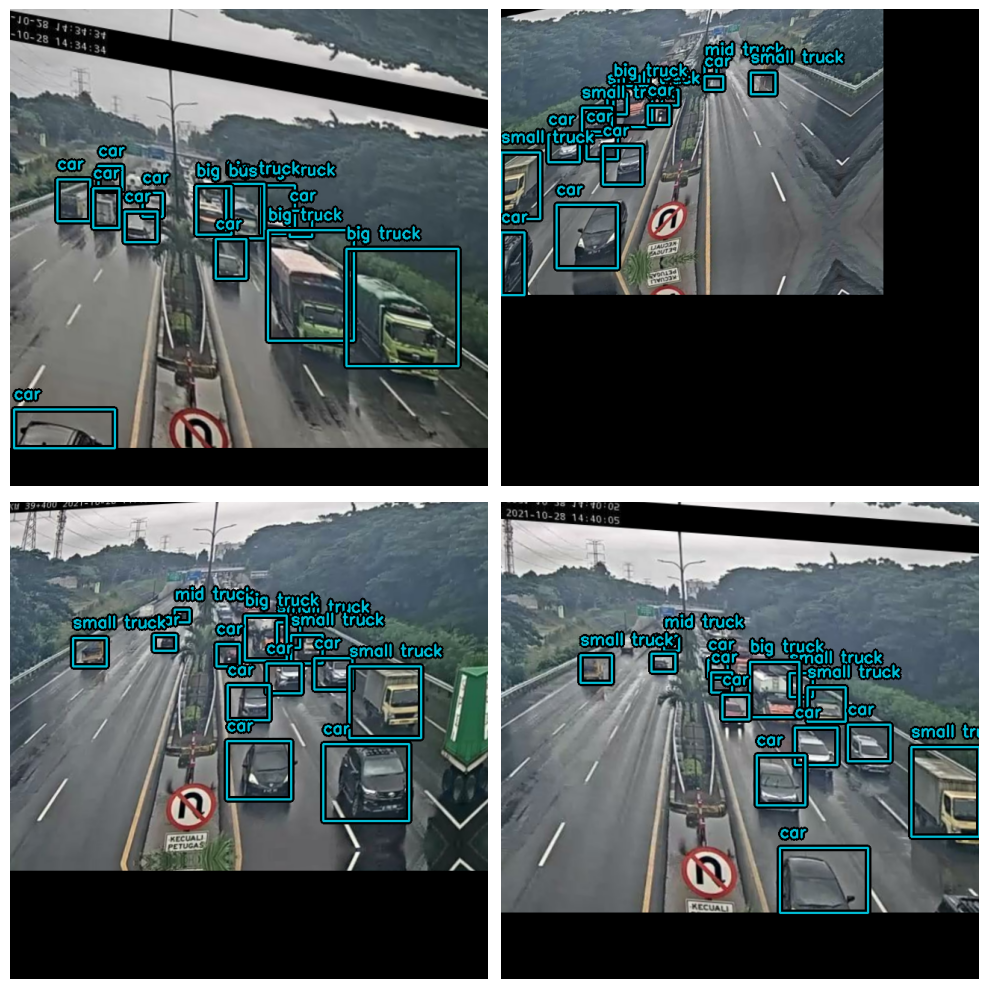

In [ ]:
# Try to visualize a small subset of your train dataset
visualize_dataset(
    train_ds.take(5), bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

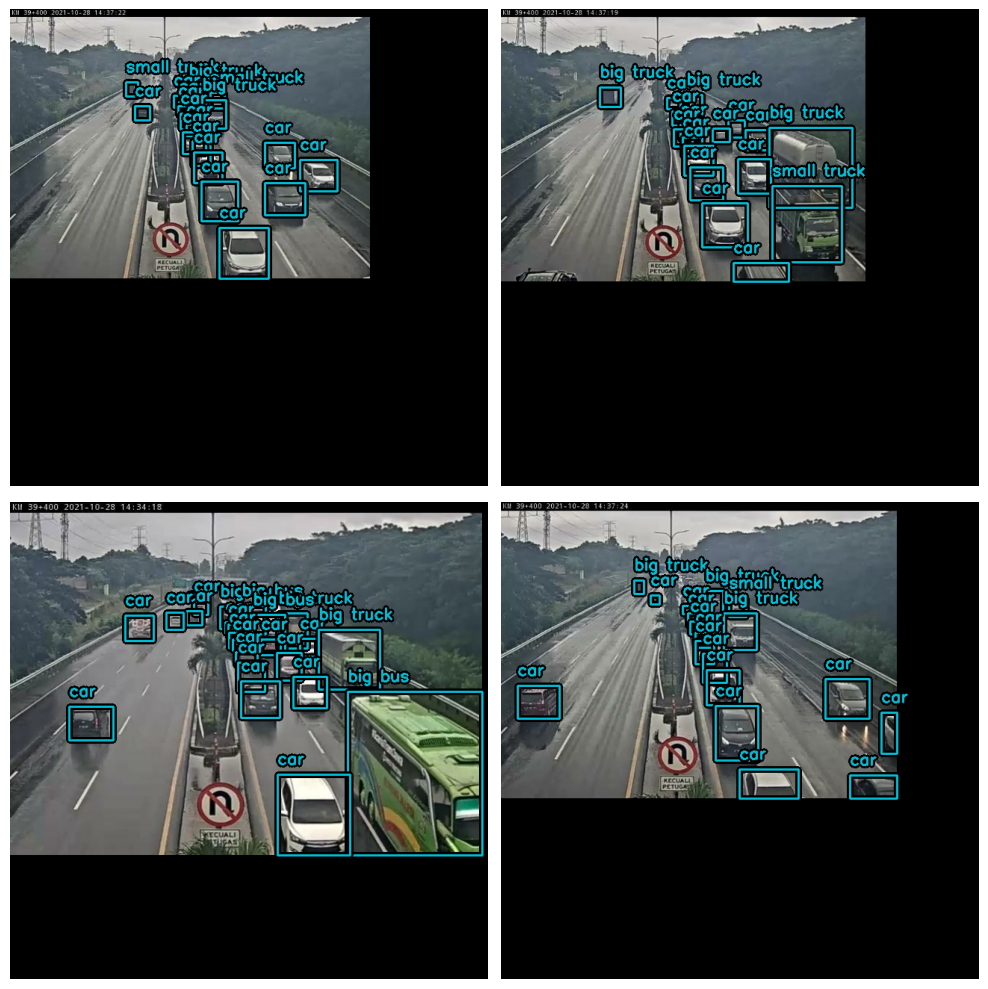

In [ ]:
# Try to visualize a small subset of your validation dataset
visualize_dataset(
    val_ds.take(5), bounding_box_format="xyxy", value_range=(0, 255), rows=2, cols=2
)

In [ ]:
# Map dataset to tuple
def dict_to_tuple(inputs):
    return inputs["images"], inputs["bounding_boxes"]

train_ds = train_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
train_ds = train_ds.prefetch(tf.data.AUTOTUNE)

val_ds = val_ds.map(dict_to_tuple, num_parallel_calls=tf.data.AUTOTUNE)
val_ds = val_ds.prefetch(tf.data.AUTOTUNE)

In [ ]:
# YOLOv8 Backbone
backbone = keras_cv.models.YOLOV8Backbone.from_preset(
    "yolo_v8_s_backbone_coco"  # We will use yolov8 small backbone with coco weights
)

20596968/20596968 [==============================] - 2s 0us/step


In [ ]:
# YOLOv8 Detector
yolo = keras_cv.models.YOLOV8Detector(
    num_classes=len(class_mapping),
    bounding_box_format="xyxy",
    backbone=backbone,
    fpn_depth=1,
)

In [ ]:
optimizer = tf.keras.optimizers.Adam(
    learning_rate=LEARNING_RATE,
    global_clipnorm=GLOBAL_CLIPNORM,
)

In [ ]:
yolo.compile(
    optimizer=optimizer, classification_loss="binary_crossentropy", box_loss="ciou"
)

In [ ]:
class EvaluateCOCOMetricsCallback(keras.callbacks.Callback):
    def __init__(self, data, save_path):
        super().__init__()
        self.data = data
        self.metrics = keras_cv.metrics.BoxCOCOMetrics(
            bounding_box_format="xyxy",
            evaluate_freq=1e9,
        )

        self.save_path = save_path
        self.best_map = -1.0

    def on_epoch_end(self, epoch, logs):
        self.metrics.reset_state()
        for batch in self.data:
            images, y_true = batch[0], batch[1]
            y_pred = self.model.predict(images, verbose=0)
            self.metrics.update_state(y_true, y_pred)

        metrics = self.metrics.result(force=True)
        logs.update(metrics)

        current_map = metrics["MaP"]
        if current_map > self.best_map:
            self.best_map = current_map
            self.model.save(self.save_path)  # Save the model when mAP improves

        return logs